In [1]:
# =========================
# TRAINING CONFIG
# =========================
CONFIG = {
    "data": {
        "csv_path":      r"C:\\Users\\rcper\\OneDrive\Desktop\\Research\\Research(2025)\DSM_and_NILM\SGN_NILM\\CLEAN_REFIT_081116\\CLEAN_House2.csv",  
        "appliance_col": "Appliance5",                    
        "max_rows":      750000,
        "resample_rule": "30s",
        "train_split":   0.70,  # 70% train, 15% val, 15% test
        "val_split":     0.85,
    },
    "model": {
        "backbone_kind": "tcn",  
        "win_len":       256,
        "reg_stride":    16,
        "cls_stride":    1,
    },
    "optim": {
        "batch_size": 32,
        "lr":         1e-3,
        "patience":   10,
        "min_delta":  0.0,
        "use_scheduler": False,
    },
    "staged_training": {
        "epochs_reg":   30,   # regressor pretrain
        "epochs_cls":   30,   # classifier pretrain
        "epochs_joint": 60,   # joint finetune
        "on_sample_prob_reg": 0.7,  # oversampling ONLY for reg batches
    },
    "loss": {
        "delta_watts":     50.0,  # Huber delta in Watts
        "alpha_on":        1.0,   
        "alpha_reg_raw":   1.0,   
        "alpha_off":       0.04,  
        "beta_cls":        1.5,   
        "focal_gamma":     3.0,   
        "pos_weight_cap":  100.0,   
    },
    "checkpoint": {
        "ckpt_path": "sgn_best.pt"
    },
    "labels": {
        "on_threshold": 30.0,
        "off_threshold": 22.0,
        "min_hold": 1,  
    },
    "early_stopping_pretrain": {
        "reg_es_patience": 5,
        "reg_es_min_delta": 0.5,
        "cls_es_patience": 5,
        "cls_es_min_delta": 0.5,
    },
    "cls_emphasis": {
        "cls_on_sample_prob": 0.35,
        "edge_sample_prob_cls": 0.35,
    },
}


In [2]:
# =========================
# IMPORTS
# =========================
import numpy as np
import torch

from dataset import Seq2PointWindows
from training import main_train_staged
from loss import delta_from_watts
from inference import (
    infer_seq2point_timeline_all,
    infer_seq2point_timeline_all_with_hard,
    tune_hysteresis_for_mae,
    smape,
)
from sgnNet import SGN
from refit_dataloader import load_house_csv

# plotting utils (decoupled)
from plot import plot_training_curves, plot_reg_vs_true, plot_soft, plot_hard, plot_mains


In [3]:
# =========================
# LOAD DATA
# =========================

mains_all, target_all, ts_all = load_house_csv(
    CONFIG["data"]["csv_path"],
    appliance_col=CONFIG["data"]["appliance_col"],
    max_rows=CONFIG["data"]["max_rows"],
    resample_rule=CONFIG["data"]["resample_rule"],
)
print(f"Loaded {len(mains_all)} samples for {CONFIG['data']['appliance_col']}")

# Split
n = len(mains_all)
train_end = int(CONFIG["data"]["train_split"] * n)
val_end   = int(CONFIG["data"]["val_split"] * n)

mains_train, target_train = mains_all[:train_end], target_all[:train_end]
mains_val,   target_val   = mains_all[train_end:val_end], target_all[train_end:val_end]
mains_test,  target_test  = mains_all[val_end:], target_all[val_end:]


Loaded 750000 samples for Appliance5


In [4]:
# =========================
# PREP DATA STATS & LOSS PARAMS
# =========================

WIN_LEN      = CONFIG["model"]["win_len"]
REG_STRIDE   = CONFIG["model"].get("reg_stride", CONFIG["model"].get("stride", 32))
CLS_STRIDE   = CONFIG["model"].get("cls_stride", CONFIG["model"].get("stride", 32))
STRIDE_STATS = max(REG_STRIDE, CLS_STRIDE)  # neutral stride for stats; could also use 1

# Label thresholds (keep consistent with training)
ON_T  = CONFIG["labels"]["on_threshold"]
OFF_T = CONFIG["labels"]["off_threshold"]
HOLD  = CONFIG["labels"]["min_hold"]

# Build small datasets JUST to compute scaling/imbalance (no sampling bias)
train_ds = Seq2PointWindows(
    mains_train, target_train,
    win_len=WIN_LEN, stride=STRIDE_STATS, train=True,
    balance_sampling=False, edge_sample_prob=0.0,
    on_threshold=ON_T, off_threshold=OFF_T, min_hold=HOLD,
)
val_ds = Seq2PointWindows(
    mains_val, target_val,
    win_len=WIN_LEN, stride=STRIDE_STATS, train=False,
    mains_mean=train_ds.mains_mean, mains_std=train_ds.mains_std,
    target_scale=train_ds.target_scale,
    on_threshold=ON_T, off_threshold=OFF_T, min_hold=HOLD,
)
test_ds = Seq2PointWindows(
    mains_test, target_test,
    win_len=WIN_LEN, stride=STRIDE_STATS, train=False,
    mains_mean=train_ds.mains_mean, mains_std=train_ds.mains_std,
    target_scale=train_ds.target_scale,
    on_threshold=ON_T, off_threshold=OFF_T, min_hold=HOLD,
)

# Huber delta in *scaled* units
delta = delta_from_watts(CONFIG["loss"]["delta_watts"], train_ds.target_scale)

# Class imbalance → pos_weight (capped, from TRAIN only)
pos_rate  = float(train_ds.onoff.mean() + 1e-9)
neg_rate  = 1.0 - pos_rate
pos_weight = min(neg_rate / pos_rate, CONFIG["loss"]["pos_weight_cap"])

# ON rates for all splits
pos_rate_train = float(train_ds.onoff.mean())
pos_rate_val   = float(val_ds.onoff.mean())
pos_rate_test  = float(test_ds.onoff.mean())

print(
    f"Stats: win={WIN_LEN}, stride_stats={STRIDE_STATS} | "
    f"scale={train_ds.target_scale:.2f} | "
    f"ON rate (train)={pos_rate_train:.4f}, "
    f"(val)={pos_rate_val:.4f}, "
    f"(test)={pos_rate_test:.4f} → "
    f"pos_weight={pos_weight:.2f} | "
    f"delta(huber)={delta:.6f} (scaled)"
)


Stats: win=256, stride_stats=16 | scale=1200.80 | ON rate (train)=0.0017, (val)=0.0351, (test)=0.0063 → pos_weight=100.00 | delta(huber)=0.041639 (scaled)


In [ ]:
# =========================
# TRAIN (STAGED)
# =========================
results = main_train_staged(
    mains_train, target_train,
    mains_val,   target_val,
    win_len=CONFIG["model"]["win_len"],
    stride_reg=CONFIG["model"]["reg_stride"],
    stride_cls=CONFIG["model"]["cls_stride"],
    batch_size=CONFIG["optim"]["batch_size"],
    lr=CONFIG["optim"]["lr"],
    epochs_reg=CONFIG["staged_training"]["epochs_reg"],
    epochs_cls=CONFIG["staged_training"]["epochs_cls"],
    epochs_joint=CONFIG["staged_training"]["epochs_joint"],
    on_sample_prob_reg=CONFIG["staged_training"]["on_sample_prob_reg"],
    kind=CONFIG["model"]["backbone_kind"],
    patience=CONFIG["optim"]["patience"],
    min_delta=CONFIG["optim"]["min_delta"],
    ckpt_path=CONFIG["checkpoint"]["ckpt_path"],
    delta_huber=delta,
    focal_gamma=CONFIG["loss"]["focal_gamma"],
    pos_weight=pos_weight,
    alpha_on=CONFIG["loss"]["alpha_on"],
    alpha_reg_raw=CONFIG["loss"]["alpha_reg_raw"],
    alpha_off=CONFIG["loss"]["alpha_off"],
    beta_cls=CONFIG["loss"]["beta_cls"],
    use_scheduler=CONFIG["optim"]["use_scheduler"],
    plot=False,  # plotting handled later via plot.py
    reg_es_patience=CONFIG["early_stopping_pretrain"]["reg_es_patience"],
    reg_es_min_delta=CONFIG["early_stopping_pretrain"]["reg_es_min_delta"],
    cls_es_patience=CONFIG["early_stopping_pretrain"]["cls_es_patience"],
    cls_es_min_delta=CONFIG["early_stopping_pretrain"]["cls_es_min_delta"],
    on_threshold=CONFIG["labels"]["on_threshold"],
    off_threshold=CONFIG["labels"]["off_threshold"],
    min_hold=CONFIG["labels"]["min_hold"],
    cls_on_sample_prob=CONFIG["cls_emphasis"]["cls_on_sample_prob"],
    edge_sample_prob_cls=CONFIG["cls_emphasis"]["edge_sample_prob_cls"],
    
)

print("Best Val MAE (W):", results["best_val_mae"])


=== DATASET DIAGNOSTICS ===
Train REG:  on_rate=0.00173  n_centers=524745
           n_on_centers=907  n_off_centers=523838
Train CLS:  on_rate=0.00173  n_centers=524745  n_edge=924
Val:        on_rate=0.03515     n_centers=112245
[REG] Epoch 001 | Train 0.1671 | ValLoss(reg-only) 0.0109 | ValMAE 140.37 | MAE@ON 141.90 | MAE@OFF 140.32
[REG] Epoch 002 | Train 0.1265 | ValLoss(reg-only) 0.0111 | ValMAE 130.88 | MAE@ON 135.96 | MAE@OFF 130.69
[REG] Epoch 003 | Train 0.0956 | ValLoss(reg-only) 0.0122 | ValMAE 134.96 | MAE@ON 144.45 | MAE@OFF 134.62
[REG] Epoch 004 | Train 0.0714 | ValLoss(reg-only) 0.0126 | ValMAE 152.03 | MAE@ON 161.69 | MAE@OFF 151.68
[REG] Epoch 005 | Train 0.0564 | ValLoss(reg-only) 0.0110 | ValMAE 123.27 | MAE@ON 140.18 | MAE@OFF 122.65
[REG] Epoch 006 | Train 0.0480 | ValLoss(reg-only) 0.0102 | ValMAE 117.92 | MAE@ON 125.85 | MAE@OFF 117.64
[REG] Epoch 007 | Train 0.0399 | ValLoss(reg-only) 0.0125 | ValMAE 151.69 | MAE@ON 171.79 | MAE@OFF 150.95
[REG] Epoch 008 | Tr

In [ ]:
# =========================
# LOAD BEST MODEL & RUN INFERENCE
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(CONFIG["checkpoint"]["ckpt_path"], map_location=device)

model = SGN(in_ch=1, hid=64, kind=CONFIG["model"]["backbone_kind"], out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

gate_tau = stats.get("gate_tau", 0.6) if isinstance(stats, dict) else 0.75

print(gate_tau)

# Validation inference for hysteresis tuning
pow_val_soft, reg_val_w, prob_val = infer_seq2point_timeline_all(model, mains_val, stats, device, gate_tau=gate_tau)
y_val = target_val
t_on, t_off, min_hold, best_val_mae = tune_hysteresis_for_mae(reg_val_w, prob_val, y_val, gate_floor=0.0)
print(f"[HYSTERESIS][VAL] best → t_on={t_on:.2f}, t_off={t_off:.2f}, min_hold={min_hold} | MAE={best_val_mae:.2f} W")

# Test inference (soft + hard)
power_soft_w, reg_w, prob, gate_hard, power_hard_w = infer_seq2point_timeline_all_with_hard(
    model, mains_test, stats, device,
    gate_tau=gate_tau,
    t_on=t_on, t_off=t_off, min_hold=min_hold,
    gate_floor=0.0
)
y_true = target_test

# Metrics
mae_soft = float(np.mean(np.abs(power_soft_w - y_true)))
mae_hard = float(np.mean(np.abs(power_hard_w - y_true)))
energy_true = float(y_true.sum())
sae_soft = float(abs(power_soft_w.sum() - energy_true) / (energy_true + 1e-6))
sae_hard = float(abs(power_hard_w.sum() - energy_true) / (energy_true + 1e-6))
print(f"[TEST][SOFT] MAE={mae_soft:.2f} W | SAE={sae_soft:.4f} | sMAPE={smape(y_true, power_soft_w):.2f}%")
print(f"[TEST][HARD] MAE={mae_hard:.2f} W | SAE={sae_hard:.4f} | sMAPE={smape(y_true, power_hard_w):.2f}%")


0.6
[HYSTERESIS][VAL] best → t_on=0.85, t_off=0.20, min_hold=2 | MAE=8.81 W
[TEST][SOFT] MAE=19.25 W | SAE=0.7315 | sMAPE=95.25%
[TEST][HARD] MAE=14.30 W | SAE=0.3789 | sMAPE=3.96%


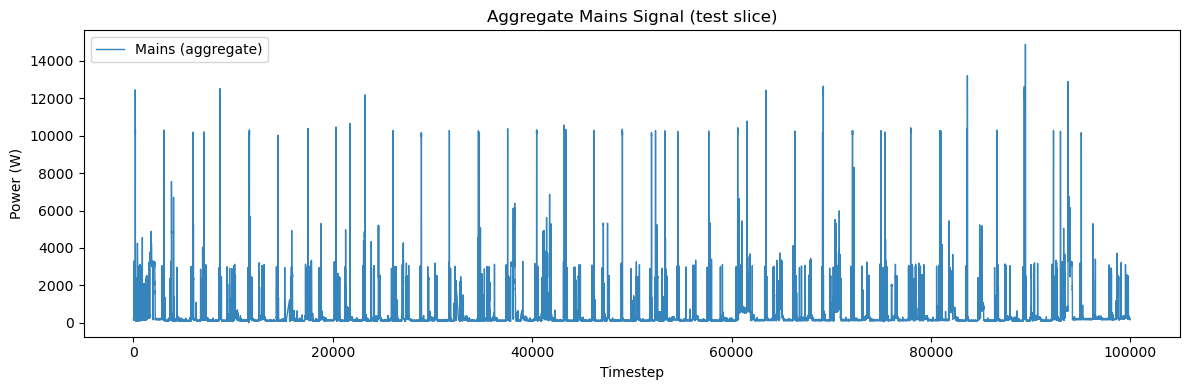

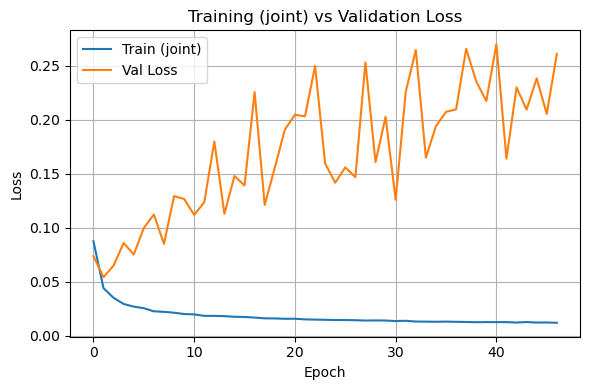

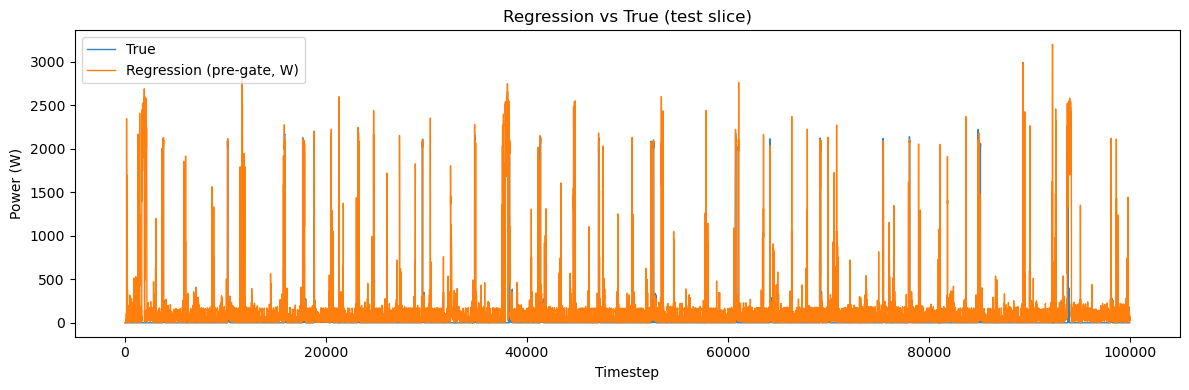

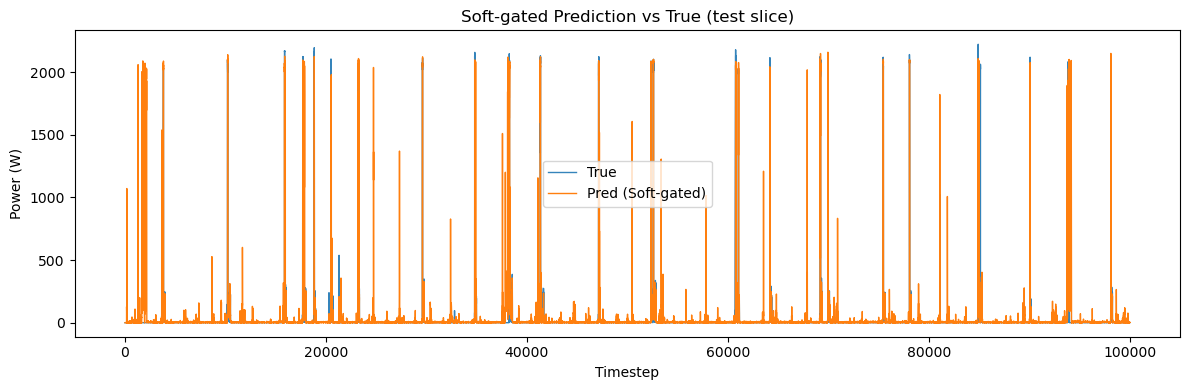

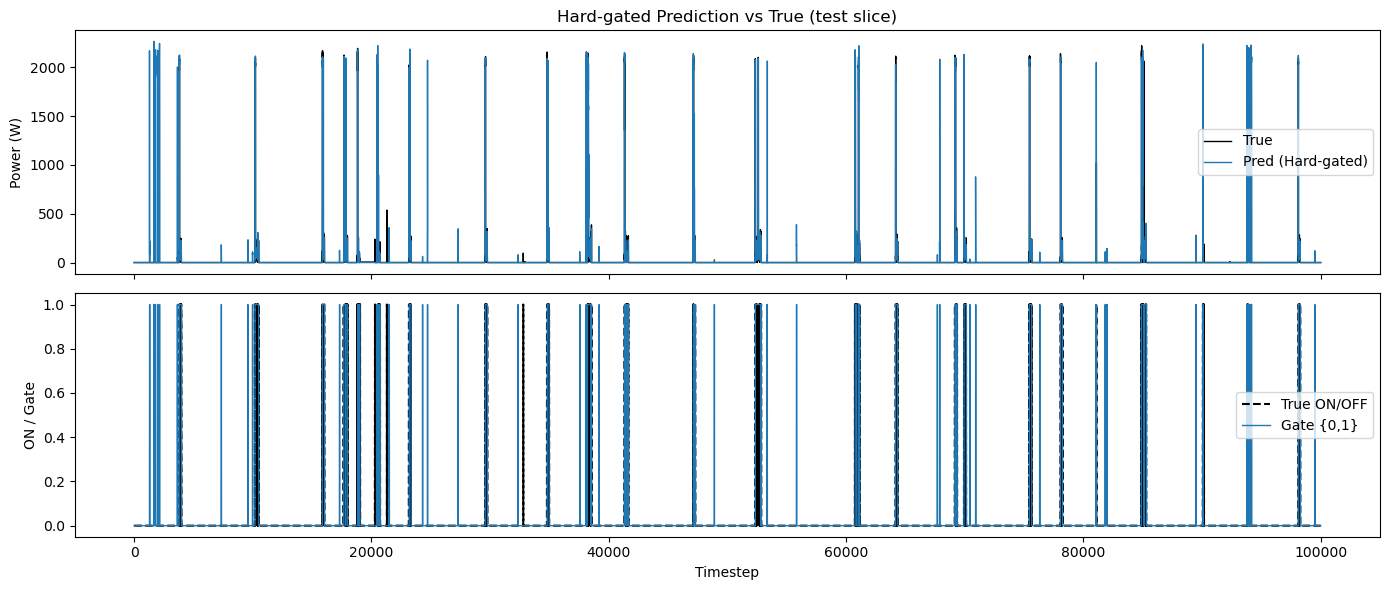

In [ ]:
# =========================
# PLOTS 
# =========================
PLOT_CFG = {
    "enable_training_curve": True,
    "show_regression": True,
    "show_soft": True,
    "show_hard": True,
    "test_plot_len": 100000,
    "on_threshold_for_plot": 15.0,  # for binary true_on curve in hard plot
}




N = min(PLOT_CFG["test_plot_len"], len(y_true))

plot_mains(mains_test, N=N, show=True)
plot_training_curves(results, enable=PLOT_CFG["enable_training_curve"])
plot_reg_vs_true(y_true, reg_w, N=N, show=PLOT_CFG["show_regression"])
plot_soft(y_true, power_soft_w, N=N, show=PLOT_CFG["show_soft"])
plot_hard(y_true, power_hard_w, gate_hard,
          on_threshold=PLOT_CFG["on_threshold_for_plot"],
          N=N, show=PLOT_CFG["show_hard"])
